<a href="https://colab.research.google.com/github/seokhee516/Project2-Credit-Scoring-System/blob/main/%EB%AC%B8%EC%A0%9C%EC%A0%95%EC%9D%98_%EB%B0%8F_EDAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 문제정의

이번 프로젝트 주제는 **"씬파일러를 위한 신용평가 예측모형"** 입니다.  
 씬파일러(Thin filer)란, 금융 거래가 적거나 없어 관련 서류가 얇은 금융고객을 의미합니다. 주로 사회초년생, 주부, 은퇴자들이 이에 속해 있으며, 이들은 중저신용등급으로 책정되어 제도권 금융을 이용할 기회가 줄어들게 됩니다.
 이처럼 금융이력이 부족한 이들의 채무불이행을 예측하고, 더 나아가 신파일러들의 금융 불이익을 해소 할 수 있는 신용평가를 제공하는 것이 이번 프로젝트의 목적입니다.




프로젝트에 사용할 데이터는 **"Lending Club(렌딩 클럽)"** 데이터입니다.  
렌딩 클럽은 미국 유명 P2P 대출 업체로서, 신용등급이 낮아 제도권 금융기관에서 대출을 받을 수 없는 씬파일러에게 대안금융 역할을 하고 있습니다. 캐글에서 제공하고 있는 'Lending Club 2007-2020Q3' 데이터세트의 2017년부터 2020년 3분기 데이터를 활용하여 본 프로젝트를 진행하겠습니다.  



In [148]:
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Late (31-120 days)', 'Charged Off',
       'In Grace Period', 'Late (16-30 days)', 'Default', 'Issued'],
      dtype=object)

# 2. EDA 및 데이터 전처리

## 2.1 데이터 및 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [61]:
df = pd.read_csv('LendingClub_Loan_status_2017-2020Q3.csv').iloc[:,1:]
df.head()

id  loan_amnt  ...  hardship_last_payment_amount  debt_settlement_flag
0  120122535    12000.0  ...                           NaN                     N
1  119374887    32000.0  ...                       1062.71                     N
2  119321612    40000.0  ...                           NaN                     N
3  120122034    16000.0  ...                           NaN                     N
4  118659541    33000.0  ...                         59.68                     N

[5 rows x 141 columns]

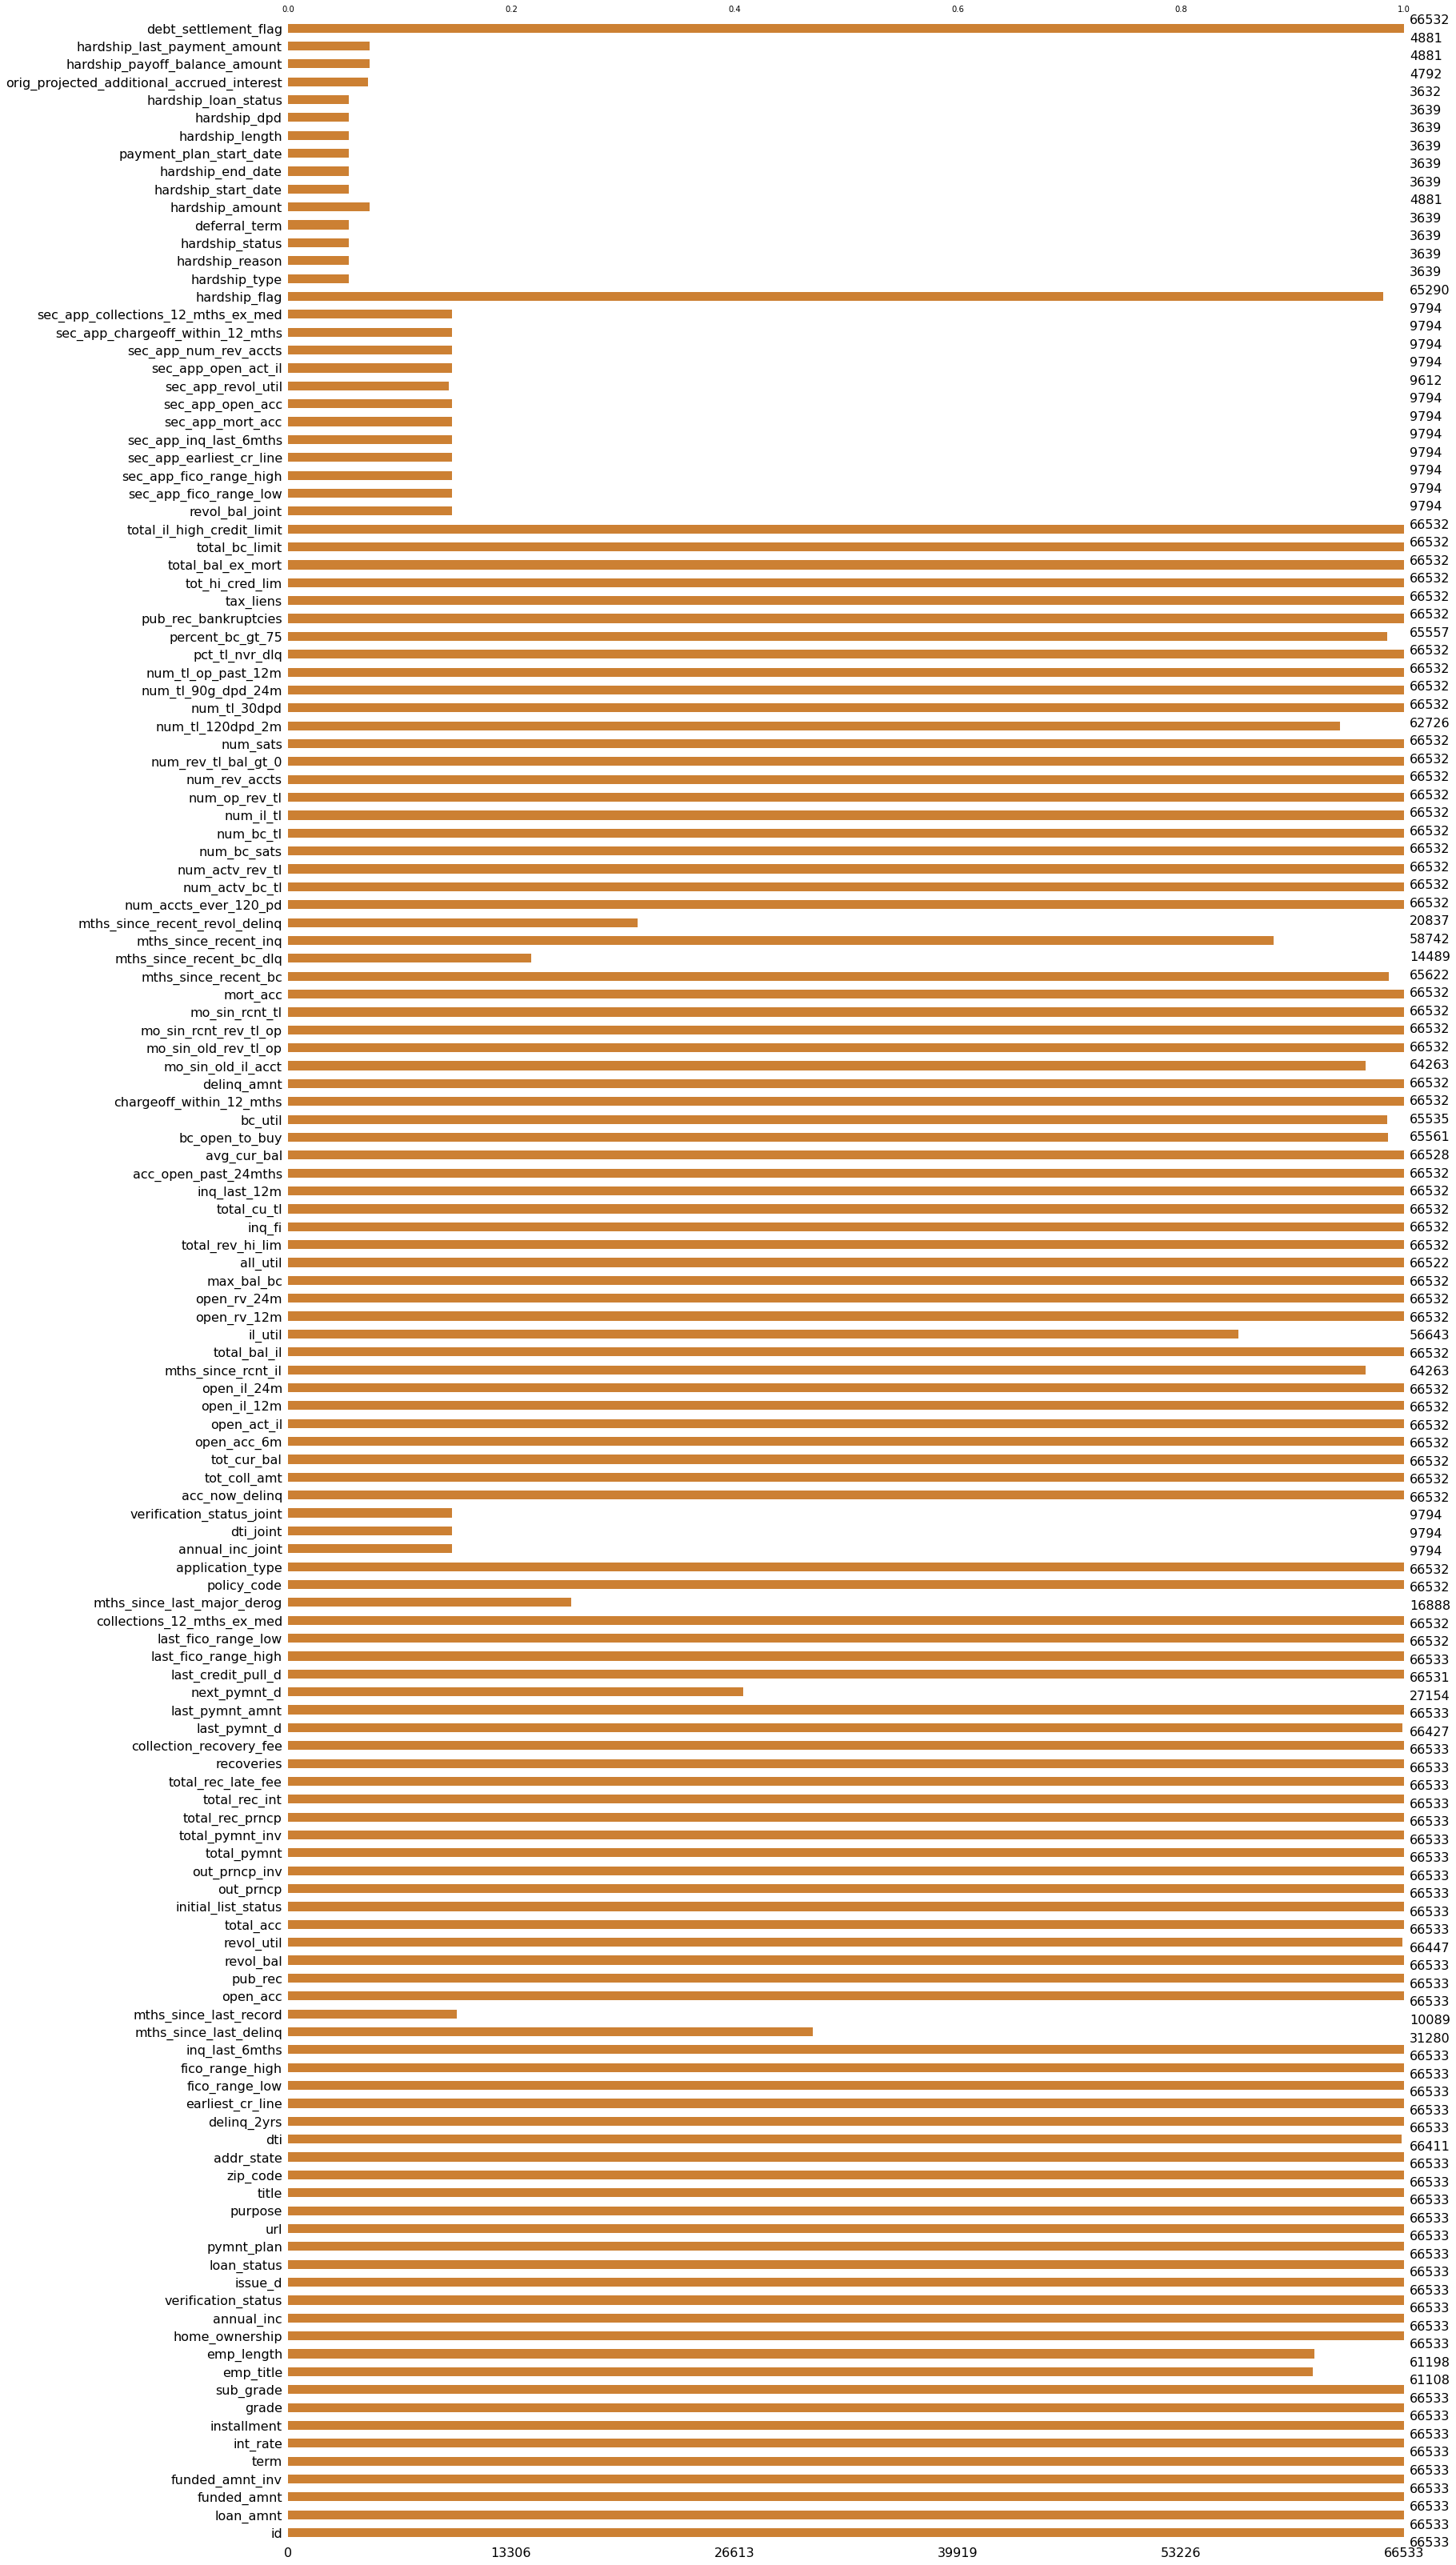

In [ ]:
msno.bar(df=df.iloc[:, :], color=(0.8, 0.5, 0.2))

## 2.2 데이터 전처리

1. 대출 후 생성 변수 제거
2. 최빈값의 빈도가 99% 이상인 범주형 변수 제거
3. 범주의 수가 50개 이상인 변수 제거
4. 범주형 데이터 타입 정리
5. 결측값 절반 이상 칼럼 제거


(수치형 결측값 평균값으로 대체, 이상치 IQR 1.5배 밖에 있는 데이터 제거)

### 2.2.1 대출 후 생성 변수 제거  
렌딩클럽 데이터에는 대출 생성 전에는 존재하지 않는 대출 수 생성 변수가 존재한다. 대출 후 생성 변수는 모형에 학습될 경우, 과적합될 가능성이 높아진다.   
recoveries와 같은 변수는 추심된 금액 중 회복된 금액을 설명한다. 이와 유사하게 대출 후 생성 변수 30개를 제거한다. 

In [64]:
recoveries_list = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'hardship_flag',
'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount',
'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
'hardship_last_payment_amount']

In [80]:
df.drop(columns=recoveries_list,axis=1, inplace=True)

### 2.2.2 최빈값의 빈도가 99% 이상인 범주형 변수 제거  
최빈값의 빈도가 99% 이상인 범주형 변수는 모형에 학습된다고 해도 결과 변수에 영향을 주지못한다.


In [90]:
mode_99_list = ['pymnt_plan', 'policy_code', 'debt_settlement_flag']

In [93]:
df.drop(columns=mode_99_list,axis=1, inplace=True)

### 2.2.3 범주의 수가 50개 이상인 변수 제거

In [94]:
selected_cols = df.select_dtypes(include=['number', 'object'])
colnames = selected_cols.columns.tolist()
labels = selected_cols.nunique()

selected_features = labels[labels <= 50].index.tolist()
df = df[selected_features]

### 2.2.4 범주형 데이터 타입 정리
emp_length는 재직 기간을 의미하는 변수로, 범주의 수가 10개 이상으로 dummy encoding을 진행할 경우 차원이 10개 이상 늘어나게 된다. 따라서 이를 방지하기 위해 범주군을 묶어주었다.
- less than 3 years: 1년 이하 ~ 3년
- more than 4 years and less than 9 years: 4년 ~ 9년
- 10+ years: 10년 이상
- unemployed: nan

In [129]:
df.loc[(df['emp_length']== '< 1 year')|(df['emp_length']== '1 year')|(df['emp_length']== '2 years')|(df['emp_length']== '3 years'),'emp_length'] = 'less than 3 years'

In [128]:
df.loc[(df['emp_length']== '4 years')|(df['emp_length']== '5 years')|(df['emp_length']== '6 years')|(df['emp_length']== '7 years')|(df['emp_length']== '8 years')|(df['emp_length']== '9 years'),'emp_length'] = 'more than 4 years and less than 9 years'

In [135]:
df['emp_length'].fillna('unemployed', inplace=True)

purpose의 경우 대출 목적의 의미를 가진 변수로, 이 또한 범주군을 묶어주었다.
- General loan debt: car, home_improvement, house, major_purchase, medical, moving,
other, renewable_energy, small_business, vacation, wedding 
- credit_card: credit_card
- debt_consolidation: debt_consolidation

In [137]:
df.loc[(df['purpose']== 'car')|(df['purpose']== 'home_improvement')|(df['purpose']== 'house')|(df['purpose']== 'major_purchase')|
       (df['purpose']== 'medical')|(df['purpose']== 'moving')|(df['purpose']== 'other')|(df['purpose']== 'renewable_energy')|(df['purpose']== 'small_business')|
       (df['purpose']== 'vacation')|(df['purpose']== 'wedding'),'purpose'] = 'General loan debt'

### 2.2.5 결측값 절반 이상 칼럼 제거

In [142]:
df.dropna(thresh=int(len(df) * 0.5), axis=1, inplace=True)

## 2.3 EDA

In [144]:
df.shape

(523215, 39)

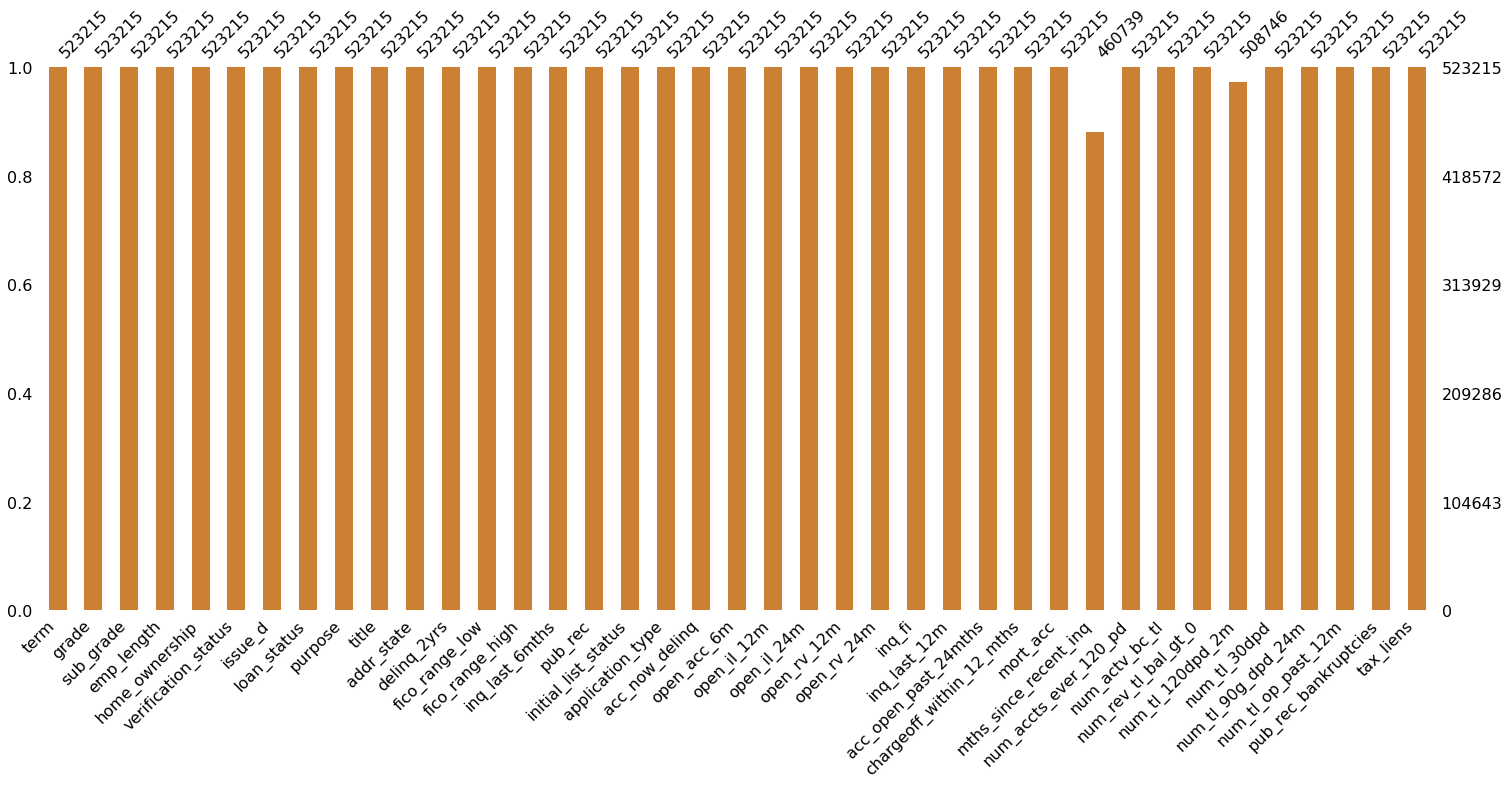

In [143]:
msno.bar(df=df.iloc[:, :], color=(0.8, 0.5, 0.2))

In [145]:
df.loan_status

0                 Fully Paid
1                    Current
2                    Current
3                    Current
4         Late (31-120 days)
                 ...        
523210               Current
523211            Fully Paid
523212           Charged Off
523213            Fully Paid
523214            Fully Paid
Name: loan_status, Length: 523215, dtype: object